## 단계별 프로세스

1. 데이터 불러오기
2. 데이터 종류 및 개수 확인
3. 데이터 특성 파악(요약 통계량, 상관관계, histogram)
4. 데이터 정제(전처리) (변수제거, 정규화)
5. 오토인코더 모델 구축(잡음제거)
6. 훈련 데이터/ 테스트 데이터 분할
7. 초매개변수, 손실 함수 및 옵티마이저 정의
8. 오토인코더 학습 함수 정의 및 학습
9. 임계값 정의 후 결과 분석 및 해석
10. MinMaxScaler를 통한 데이터 정규화 가이드

# 라이브러리/ 데이터 불러오기

In [2]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch
import numpy as np
import pandas as pd
import sklearn.metrics as metric
from sklearn import preprocessing
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
"""pandas를 이용해서 엑셀 파일인 welding_data.xlsx를 불러옵니다.
index_col을 사용해서 idx로 인덱스의 열을 설정합니다.
임시로 데이터의 앞 부분만 출력했습니다."""
welding_data = pd.read_excel('./welding_data.xlsx', index_col='idx')
welding_data.head()

,Machine_Name,Item No,working time,Thickness 1(mm),Thickness 2(mm),weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
idx,,,,,,,,,
1,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.33,14.57,2.701,72.0
2,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.36,14.57,2.701,72.0
3,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.37,14.54,2.703,71.0
4,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.37,14.54,2.703,72.0
5,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.36,14.56,2.704,72.0


# 데이터 종류 및 개수 확인

In [13]:
# 데이터의 특성들이 어떤 값들을 가지고 있으며 몇 개씩 가지고 있는 지 확인
for feature in welding_data:
    print(welding_data[feature].value_counts())

Machine_Name
Spot-01    11939
Name: count, dtype: int64
Item No
65235-25800    11939
Name: count, dtype: int64
working time
2020-04-02    2000
2020-03-31    1800
2020-03-27    1648
2020-03-30    1470
2020-03-25    1352
2020-03-24    1200
2020-03-26    1000
2020-04-03     800
2020-04-07     669
Name: count, dtype: int64
Thickness 1(mm)
0.7    11939
Name: count, dtype: int64
Thickness 2(mm)
0.7    11939
Name: count, dtype: int64
weld force(bar)
2.31    1237
2.33    1062
2.35    1047
2.32    1036
2.36    1030
        ... 
3.74       4
7.87       4
2.23       2
2.19       2
2.36       2
Name: count, Length: 177, dtype: int64
weld current(kA)
14.73    1284
14.74    1276
14.75    1002
14.72     771
14.59     630
14.76     612
14.71     553
14.58     544
14.60     431
14.57     378
14.77     350
14.78     318
14.70     312
14.56     296
14.55     278
14.61     260
14.80     216
14.81     204
14.83     192
14.62     154
14.85     144
14.67     142
14.64     132
14.54     130
14.93     128
14.9

1. 용접 기계 spot-1 11939번 작업을 완료함.
2. 작업은 2020년도 4월 2일 날 가장 많이 진행됨.

# 데이터 특성 파악

In [50]:
# 용접머신 spot-1의 데이터 통계량을 확인합니다.
welding_data[['Thickness 1(mm)', 'Thickness 2(mm)', 'weld force(bar)', 'weld current(kA)', 'weld Voltage(v)', 'weld time(ms)']].describe()

,Thickness 1(mm),Thickness 2(mm),weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
count,11939.0,11939.0,11939.000000,11939.000000,11939.000000,11939.000000
mean,0.7,0.7,2.787925,14.711208,2.704223,71.724123
std,0.0,0.0,1.455966,0.099000,0.024700,0.632049
min,0.7,0.7,1.740000,14.520000,2.464000,70.000000
25%,0.7,0.7,2.310000,14.610000,2.699000,71.000000
50%,0.7,0.7,2.340000,14.730000,2.702000,72.000000
75%,0.7,0.7,2.370000,14.750000,2.706000,72.000000
max,0.7,0.7,10.540000,15.070000,2.861000,73.000000


1. count : 작업한 수
2. mean : 평균
3. std : 표준편차
4. min : 최소값
5. 25%, 50%, 75% : 0과 1사이의 백분위 수.
6. max : 최대값

# 용접 제품/ corr 함수를 통한 변수 간 상관 관계 파악 가이드
- 데이터 변수 간의 상관 관계를 확인할 수 있다.
- 분석에서 사용된 상관 계수는 피어슨 상관 계수로 -1과 1사이의 값을 가집니다. 상관 계수의 절대값이 1에 가까울 수록 변수 간의 선형 관계가 강하다고 볼 수 있으며, 값이 양수일 때는 양적인 선형 관계, 음수일 때는 음적인 선형 관계를 가집니다. 상관 계수의 절댓값이 
0.1 ~ 0.3 : 약한 선형 관계,
0.3 ~ 0.7 : 뚜렷한 선형 관계,
0.7 이상 : 강한 선형 관계.

In [93]:
welding_data[['Thickness 1(mm)', 'Thickness 2(mm)', 'weld force(bar)', 'weld current(kA)', 'weld Voltage(v)', 'weld time(ms)']].corr(method='pearson')

,Thickness 1(mm),Thickness 2(mm),weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
Thickness 1(mm),NaN,NaN,NaN,NaN,NaN,NaN
Thickness 2(mm),NaN,NaN,NaN,NaN,NaN,NaN
weld force(bar),NaN,NaN,1.000000,0.411675,0.133876,-0.005557
weld current(kA),NaN,NaN,0.411675,1.000000,0.129596,-0.020933
weld Voltage(v),NaN,NaN,0.133876,0.129596,1.000000,0.010169
weld time(ms),NaN,NaN,-0.005557,-0.020933,0.010169,1.000000


# 용접 제품/히스토그램을 통한 변수별 데이터 파악

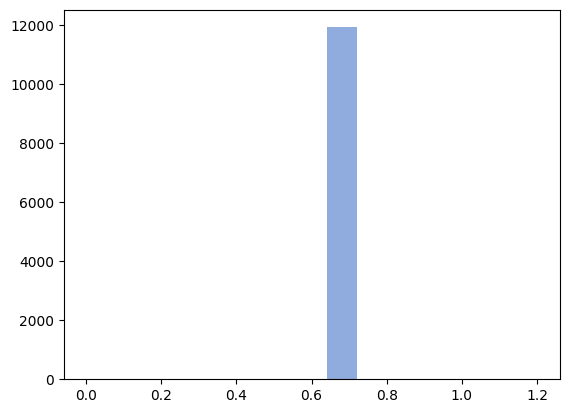

In [117]:
b = [15, 15, 25, 13, 17, 15, 35]
%matplotlib inline

thickness_1 = plt.hist(welding_data['Thickness 1(mm)'], bins = b[0], facecolor = (144 /255,171 /255,221 /255), range=(0, 1.2))

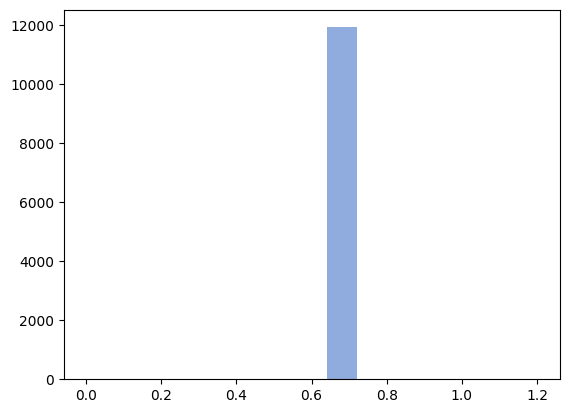

In [118]:
thickness_2 = plt.hist(welding_data['Thickness 2(mm)'], bins = b[1], facecolor = (144 /255,171 /255,221 /255), range=(0, 1.2))

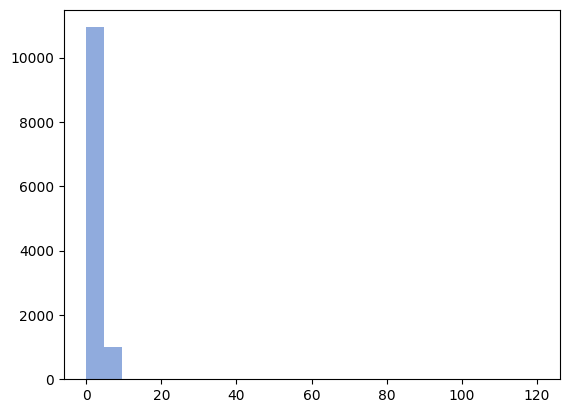

In [119]:
weld_force = plt.hist(welding_data['weld force(bar)'], bins = b[2], facecolor = (144 /255,171 /255,221 /255), range=(0, 120))



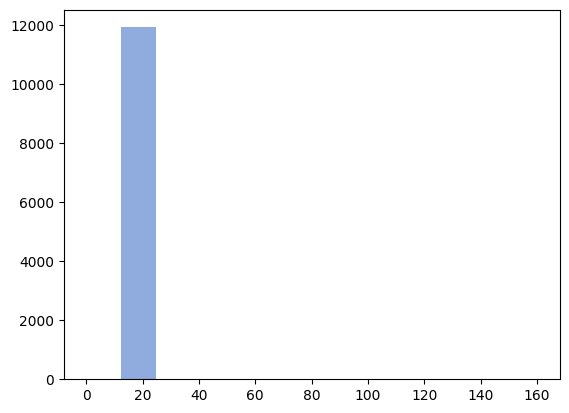

In [120]:
weld_current = plt.hist(welding_data['weld current(kA)'], bins = b[3], facecolor = (144 /255,171 /255,221 /255), range=(0, 160))



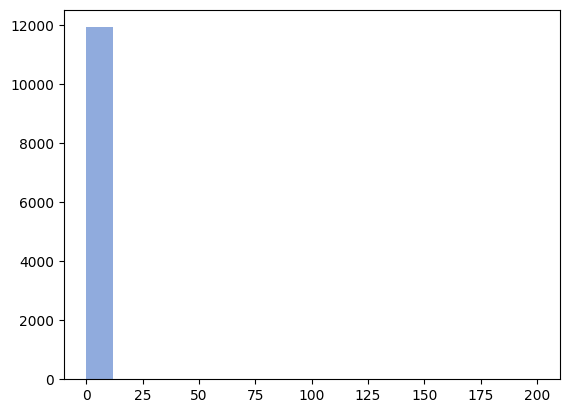

In [121]:
weld_Voltage = plt.hist(welding_data['weld Voltage(v)'], bins = b[4], facecolor = (144 /255,171 /255,221 /255), range=(0, 200))



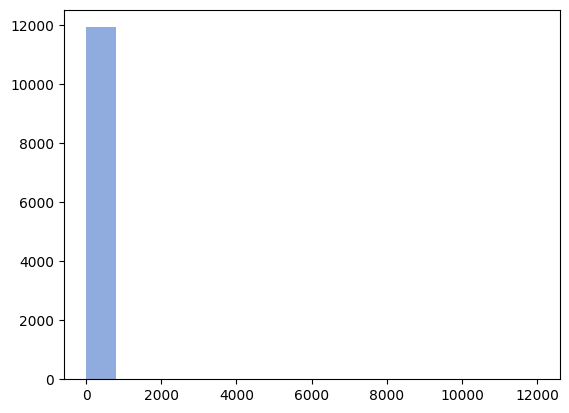

In [122]:
weld_time = plt.hist(welding_data['weld time(ms)'], bins = b[5], facecolor = (144 /255,171 /255,221 /255), range=(0, 12000))

# 데이터 정제(전처리)
- 데이터 품질 검사, 데이터 전처리 

In [4]:
# 불필요한 데이터 제외 가이드
# 생산 품목, 작업시간, 소재두께를 제외
new_welding_data = welding_data.iloc[:, 5:]
new_welding_data.head()

,weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
idx,,,,
1,2.33,14.57,2.701,72.0
2,2.36,14.57,2.701,72.0
3,2.37,14.54,2.703,71.0
4,2.37,14.54,2.703,72.0
5,2.36,14.56,2.704,72.0


In [6]:
# MinMaxScaler를 통해 최소 - 최대 정규화
scaler = preprocessing.MinMaxScaler()
scaler.fit(new_welding_data)
scaled_data = scaler.transform(new_welding_data)
scaled_data

array([[0.06704545, 0.09090909, 0.59697733, 0.66666667],
       [0.07045455, 0.09090909, 0.59697733, 0.66666667],
       [0.07159091, 0.03636364, 0.60201511, 0.33333333],
       ...,
       [0.07159091, 0.14545455, 0.62468514, 0.33333333],
       [0.06931818, 0.01818182, 0.62468514, 0.33333333],
       [0.06931818, 0.01818182, 0.62468514, 0.33333333]])

1. sklearn.prerocessing.MinMaxScaler : This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
2. fit() : Compute the minimum and maximum to be used for later scaling.
3. .transform() : Fits transformer to X and y with optional parameters fit_params and returns a transformed version of X.

In [16]:
scaled_data_df = pd.DataFrame(scaled_data)
scaled_data_df.to_csv('my_scaled_data.csv')

# 오토인코더 모델 구축 (잡음 제거)
1. input_size : 입력의 크기, 숫자로 입력을 받음
2. hidden_size : 신경망층의 크기, 리스트 형태로 입력을 받음
3. ouput_size : 출력의 크기, 숫자로 입력을 받음
4. nn.Linear() : 완전연결망
5. nn.RReLU() : Leaky Rectified Linear Unit 활성 함수
6. nn.RReLU() : 인공신경망을 담는 컨테이너, 여기에 각 신경망 층들을 더해주어 신경망을 만듦.

In [7]:
# AutoEncoder 클래스 구현
class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(AutoEncoder, self).__init__()
        # initialize
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        # 오토인코더 구현
        self.AutoEncoder = nn.Sequential(
            #인코더 
            nn.Linear(input_size, hidden_size[0]),
            nn.RReLU(),
            nn.Linear(hidden_size[0], output_size),
            nn.RReLU(),
            # 디코더
            nn.Linear(output_size, hidden_size[0]),
            nn.RReLU(),
            nn.Linear(hidden_size[0], input_size)
        )

    def forward(self, inputs):
        output = self.AutoEncoder(inputs)

        return output
    

1. 오토인코더 모델은 pytorch package를 사용해서 구현
2. nn.Module : 모든 신경망 모듈의 기본 클래스.
3. nn.Sequential : 오토인코더 안에 들어갈 신경망층 들을 담을 컨테이너를 만들어준다.
4. 사용자가 직접 신경망 층을 어떤 식으로 구현할 지 조절 할 수 있음. (현재 인코더 부분에서 완전연결층 2개와 디코더 부분에서 완전연결층 2개로 구성되었음)

# 훈련 데이터/ 테스트 데이터 분할

In [9]:
# 기존의 데이터를 텐서 형태로 변환, 훈련세트와 테스트 세트로 나눔.

train_data = torch.Tensor(scaled_data[:8470]) # 처음부터 8469번까지 데이터를 훈련세트로 지정
print(len(train_data))

test_data = torch.Tensor(scaled_data[8470:]) # 8470번째 데이터부터 끝까지를 테스트세트로 지정
print(len(test_data))

8470
3469


1. 훈련 데이터
- 데이터 개수 : 8470개
- 불량품 개수 : 28개

2. 테스트 데이터
- 데이터 개수 : 3469개
- 불량품 개수 : 11개

3. 정규화 했던 데이터를 불러와서 Tensor함수를 이용하여 오토인코더에 들어갈 입력 값으로 넣기 위해 텐서로 변환합니다. 텐서로 변환한다는 것은 데이터의 배열로 바꾼다는 뜻과 같습니다. pytorch로 구현한 오토인코더는 텐서 형태로만 입력을 받습니다.

# 하이퍼파라미터, 손실 함수 및 옵티마이저 정의

1. 훈련 데이터

In [10]:
# 훈련 하이퍼파라미터
epoch = 50
batch_size = 64
lr = 0.01
# 모델 하이퍼파라미터
input_size = len(train_data[0])
hidden_size = [3]
output_size = 2
# 손실 함수로 제곱근 오차 사용
criterion = nn.MSELoss()
# 매개 변수 조정 방식으로 Adam 사용
optimizer = torch.optim.Adam
# 오토인코더 정의
AutoEncoder = AutoEncoder(input_size, hidden_size, output_size)

2. 테스트 데이터

In [33]:
# 훈련 하이퍼파라미터
epoch = 50
batch_size = 64
lr = 0.01
# 모델 하이퍼파라미터
input_size = len(test_data[0])
hidden_size = [3]
output_size = 2
# 손실 함수로 제곱근 오차 사용
criterion = nn.MSELoss()
# 매개 변수 조정 방식으로 Adam 사용
optimizer = torch.optim.Adam
# 오토인코더 정의
AutoEncoder = AutoEncoder(input_size, hidden_size, output_size)

1. nn.MSELoss() : 평균 제곱근 오차 계산 함수
2. torch.optim.Adam : 매개 변수 조정 방식으로 Adam으로 설정
- torch.optim : 다양한 최적화 알고리즘을 구현한 패키지
- Adam : 확률론적 최적화 방법, 저차 모멘트의 적응형 추정을 기반으로 확률론적 목적 함수의 1차 기울기 기반 최적화를 위한 알고리즘.
3. AutoEncoder(input, hidden, output) : 앞에서 구현한 오토인코더 클래스를 정의
4. 하이퍼파라미터 : 모델을 만드는 데에 있어서 모델 자체가 학습할 수 있는 매개변수와는 달리 사람이 직접 설정해 주어야 하는 변수이다.
- 훈련 하이퍼파라미터 : 에포크, 배치 사이즈, 학습률
- 모델 하이퍼파라미터 : 입력 크기, 신경망의 크기, 출력크기, 손실 함수, 매개 변수 조정 방식
- 배치 사이즈 : 학습에 사용되는 데이터를 묶은 단위, 이렇게 한 이유는 한 번에 모든 데이터를 학습하는 것보다 효율적이기 때문이라고 한다. 
- 에포크 : 전체 데이터를 한 번 학습하는 단위. 예시로 epoch = 10이면 전체 데이터를 10번 학습한다.
- 학습률 : 매개 변수를 조정하는 정도를 나타내는 계수.
5. Adam optimizer : 매개 변수 조정 방법 중 하나로 자주 쓰이는 기울기를 계산하여 매개변수를 조정해주는 경사 하강법을 업그레이드한 방식. 
- optimizer : 손실 함수의 값을 줄여나가면서 네트워크를 업데이트하는 것으로 어떤 옵티마지어를 사용하느냐에 따라 성능이 달라짐.
6. 손실 함수 : 실제 값과 예측값의 차이를 수치화 하는 함수. 이 차이를 최소화 하는 것이 목표.

# 오토인코더 학습 함수 정의 및 학습

In [11]:
# 학습 함수에 대한 정의
def train_net(AutoEncoder, data, criterion, epochs, lr_rate = 0.01):
    # Optimizer에 대한 정의
    optim = optimizer(AutoEncoder.parameters(), lr = lr_rate)
    #배치 학습을 시키기 위한 데이터 변환
    data_iter = DataLoader(data, batch_size = batch_size, shuffle=True)
    #에포크 학습
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        for x in data_iter:
            # 매개변수 0으로 초기화
            optim.zero_grad()
            output = AutoEncoder(x)
            # 입력값과 출력값 간의 차이인 손실값
            loss = criterion(x, output)
            # 손실 값을 기준으로 매개변수 조정
            loss.backward()
            optim.step()
            running_loss += loss.item()

        # 각 에포크마다 손실 값 표기
        print("epoch: {}, loss: {:.2f}".format(epoch, running_loss))
    return AutoEncoder

1. AutoEncoder.parameters() : 현재 오토인코더에 내재되어 있는 매개변수.
2. DataLoader(data, batch_size, shuffle) : Pytorch에서 제공하는 함수로, 데이터를 배치 사이즈로 나누며 shuffle은 훈련과정에서 데이터를 섞는지에 대한 여부
3. optim.zero_grad() : 매개변수를 0으로 초기화시켜주는 함수
4. loss.backward(), optim.step() : 매개변수를 손실 값을 기준으로 조정해주는 함수.
5. running_loss += loss.item() : 데이터를 학습함녀서 발생하는 손실 값을 추적하기 위한 손실 값 기록. running_loss를 통해 현재 손실값이 얼만지 알 수 있음.

- 오토인코더를 학습 시키기 위한 학습 함수 정의.
- epoch의 값만큼 학습을 반복시키기 위해 반복문 사용.

# 오토인코더 학습 과정

1. 훈련 데이터

In [12]:
# 학습 함수를 이용한 오토인코더 학습
AutoEncoder = train_net(AutoEncoder, train_data, criterion, epoch, lr)

epoch: 1, loss: 3.17
epoch: 2, loss: 1.25
epoch: 3, loss: 0.94
epoch: 4, loss: 0.89
epoch: 5, loss: 0.57
epoch: 6, loss: 0.39
epoch: 7, loss: 0.34
epoch: 8, loss: 0.31
epoch: 9, loss: 0.31
epoch: 10, loss: 0.30
epoch: 11, loss: 0.29
epoch: 12, loss: 0.29
epoch: 13, loss: 0.30
epoch: 14, loss: 0.30
epoch: 15, loss: 0.30
epoch: 16, loss: 0.30
epoch: 17, loss: 0.29
epoch: 18, loss: 0.30
epoch: 19, loss: 0.30
epoch: 20, loss: 0.29
epoch: 21, loss: 0.30
epoch: 22, loss: 0.29
epoch: 23, loss: 0.29
epoch: 24, loss: 0.29
epoch: 25, loss: 0.29
epoch: 26, loss: 0.29
epoch: 27, loss: 0.29
epoch: 28, loss: 0.30
epoch: 29, loss: 0.30
epoch: 30, loss: 0.29
epoch: 31, loss: 0.29
epoch: 32, loss: 0.29
epoch: 33, loss: 0.30
epoch: 34, loss: 0.29
epoch: 35, loss: 0.29
epoch: 36, loss: 0.30
epoch: 37, loss: 0.30
epoch: 38, loss: 0.29
epoch: 39, loss: 0.29
epoch: 40, loss: 0.29
epoch: 41, loss: 0.29
epoch: 42, loss: 0.30
epoch: 43, loss: 0.29
epoch: 44, loss: 0.29
epoch: 45, loss: 0.30
epoch: 46, loss: 0.

2. 테스트 데이터

In [35]:
# 학습 함수를 이용한 오토인코더 학습
AutoEncoder = train_net(AutoEncoder, test_data, criterion, epoch, lr)

epoch: 1, loss: 11.04
epoch: 2, loss: 1.55
epoch: 3, loss: 1.45
epoch: 4, loss: 1.42
epoch: 5, loss: 1.38
epoch: 6, loss: 1.27
epoch: 7, loss: 1.13
epoch: 8, loss: 1.02
epoch: 9, loss: 1.00
epoch: 10, loss: 0.97
epoch: 11, loss: 0.93
epoch: 12, loss: 0.86
epoch: 13, loss: 0.62
epoch: 14, loss: 0.45
epoch: 15, loss: 0.41
epoch: 16, loss: 0.39
epoch: 17, loss: 0.37
epoch: 18, loss: 0.36
epoch: 19, loss: 0.34
epoch: 20, loss: 0.32
epoch: 21, loss: 0.31
epoch: 22, loss: 0.29
epoch: 23, loss: 0.30
epoch: 24, loss: 0.28
epoch: 25, loss: 0.28
epoch: 26, loss: 0.27
epoch: 27, loss: 0.28
epoch: 28, loss: 0.27
epoch: 29, loss: 0.26
epoch: 30, loss: 0.26
epoch: 31, loss: 0.27
epoch: 32, loss: 0.25
epoch: 33, loss: 0.25
epoch: 34, loss: 0.27
epoch: 35, loss: 0.25
epoch: 36, loss: 0.25
epoch: 37, loss: 0.26
epoch: 38, loss: 0.26
epoch: 39, loss: 0.25
epoch: 40, loss: 0.26
epoch: 41, loss: 0.25
epoch: 42, loss: 0.24
epoch: 43, loss: 0.25
epoch: 44, loss: 0.25
epoch: 45, loss: 0.25
epoch: 46, loss: 0

- 앞에서 정의해준 하이퍼파라미터와 학습 함수를 이용하여 오토인코더를 학습시켜준다.
- 오토인코더를 학습하며 에포크마다 손실 값을 출력해준다.

# 임계값 정의

1. 훈련 데이터

In [13]:
# 훈련세트의 손실 값 이용한 임계값 정의
train_loss_chart = []
for data in train_data:
    output = AutoEncoder(data)
    loss = criterion(output, data)
    train_loss_chart.append(loss.item())

threshold = np.mean(train_loss_chart) + np.std(train_loss_chart)*8
print("Threshold : ", threshold)

Threshold :  0.07836216916231753


2. 테스트 데이터

In [36]:
# 테스트세트의 손실 값 이용한 임계값 정의
test_loss_chart = []
for data in test_data:
    output = AutoEncoder(data)
    loss = criterion(output, data)
    test_loss_chart.append(loss.item())

threshold = np.mean(test_loss_chart) + np.std(test_loss_chart)*8
print("Threshold : ", threshold)

Threshold :  0.10675619971291087


- 임계값 : 이상치 탐지를 위해 어떤 데이터를 이상치로 판별하는 기준이 되는 값. 판별 기준은 손실 값.

# 결과 분석

In [18]:
# 훈련 세트의 손실값 이용한 임계값 정의
train_test_loss_chart = []
for data in train_data:
    output = AutoEncoder(data)
    loss = criterion(output, data)
    train_test_loss_chart.append(loss.item())

outlier = list(train_test_loss_chart >= threshold)
outlier.count(True)

39

In [21]:
# 테스트 세트의 손실값 이용한 임계값 정의
test_set_loss_chart = []
for data in test_data:
    output = AutoEncoder(data)
    loss = criterion(output, data)
    test_set_loss_chart.append(loss.item())

outlier = list(test_set_loss_chart >= threshold)
outlier.count(True)

13

- 임계값과 훈련한 오토인코더로 테스트 데이터에 적용한다.
- 반복문을 이용하여 데이터를 하나씩 오토인코더에 입력시키며 손실 값을 측정한다.
- train_test_loss_char, test_set_loss_char 리스트에 손실 값들을 기록.
- outlier.count : 불량품이 몇 개인지 출력.

# 결과
- 훈련 데이터에서는 8470개의 제품 중에 28개가 불량이었음. 오토인코더의 결과에는 39개의 제품이 불량품이라고 판별했음(11개 차이가 난다).
- 현재 테스트 데이터에서는 3469개의 제품 중에 11개의 제품이 불량인데 오토인코더의 결과는 13개의 제품이 불량품이라고 판별했음(2개 차이가 난다). 
- 위는 일별 불량품 개수 예측에 대한 결과이고, 정량적 개별 제품에 대한 불량품 판별의 성능을 보기 위해서는 목표치가 주어진 데이터가 있어야 한다. 